# Tutorial: creating and comparing graph and timeseries embeddings
The following notebook provides a demonstration how to create and compare embeddings from a timeseries and graphs created from this timeseries with different methods.

In [12]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)


from core.model import Timeseries, TimeseriesPreprocessing, TimeseriesPreprocessingSegmentation, TimeseriesPreprocessingSlidingWindow, TimeseriesPreprocessingComposite, TimeseriesView, TimeGraph, ToSequenceVisitorSlidingWindow, ToSequenceVisitor, ToSequenceVisitorOrdinalPartition
from tsg_io.input import CsvFile, TsFile
from from_graph.strategy_to_time_sequence import StrategyNextValueInNodeRandom, StrategyNextValueInNodeRandomForSlidingWindow, StrategyNextValueInNodeRoundRobin, StrategyNextValueInNodeRoundRobinForSlidingWindow, StrategySelectNextNodeRandomlyFromNeighboursAcrossGraphs, StrategySelectNextNodeRandomlyFromNeighboursFromFirstGraph, StrategySelectNextNodeRandomly, StrategySelectNextNodeRandomDegree, StrategySelectNextNodeRandomWithRestart, StrategyNextValueInNodeOrdinalPartition
from to_graph.strategy_linking_graph import StrategyLinkingGraphByValueWithinRange, LinkNodesWithinGraph
from to_graph.strategy_linking_multi_graphs import LinkGraphs
from to_graph.strategy_to_graph import BuildTimeseriesToGraphNaturalVisibilityStrategy, BuildTimeseriesToGraphHorizontalVisibilityStrategy, BuildTimeseriesToGraphOrdinalPartition, BuildTimeseriesToGraphQuantile
from embeddings.ts2g2_embeddings import EmbeddingRanking, VisitorGraphEmbeddingModelDoc2Vec, VisitorTimeseriesEmbeddingModelTS2Vec, TrainGraphEmbeddingModel, TrainTimeseriesEmbeddingModel
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Accessing data
We first get path to the data.

In [13]:
apple_path = os.path.join(os.getcwd(), "apple", "APPLE.csv")
path = CsvFile(apple_path, "Close").from_csv()

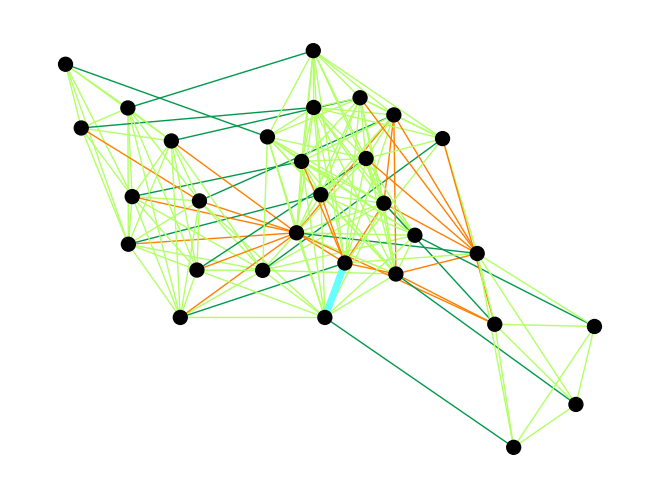

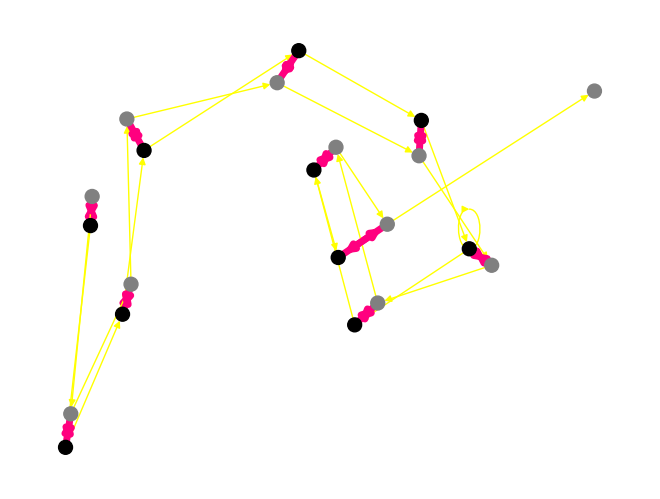

In [14]:
timegraph_natural_visibility = Timeseries(CsvFile(apple_path, "Close").from_csv())\
    .with_preprocessing(TimeseriesPreprocessingSegmentation(60, 90))\
    .to_graph(BuildTimeseriesToGraphNaturalVisibilityStrategy().with_limit(1).get_strategy())\
    .add_edge(0,2)\
    .add_edge(13, 21, weight = 17)\
    .link(LinkNodesWithinGraph().by_value(StrategyLinkingGraphByValueWithinRange(2)).seasonalities(15))\
    .draw()

timegraph_ordinal_partition = Timeseries(CsvFile(apple_path, "Close").from_csv())\
    .with_preprocessing(TimeseriesPreprocessingSegmentation(60, 120))\
    .add(Timeseries(CsvFile(apple_path, "Close").from_csv())\
        .with_preprocessing(TimeseriesPreprocessingSegmentation(120, 180)))\
    .to_histogram(15)\
    .to_graph(BuildTimeseriesToGraphOrdinalPartition(10, 5).get_strategy())\
    .link(LinkGraphs().time_cooccurrence())\
    .draw()

Then we set parameters and train models for creating embeddings.

In [15]:
apple_path = os.path.join(os.getcwd(), "apple", "APPLE.csv")
path = CsvFile(apple_path, "Close").from_csv()
embedding_size = 20

# to train graph embedding model, we need to provide multiple graphs. We chose arbitrary two as an example.
model_graph = TrainGraphEmbeddingModel().train_model([timegraph_natural_visibility, timegraph_ordinal_partition], embedding_size)
model_ts = TrainTimeseriesEmbeddingModel().train_model(path, embedding_size, epoch=20)

model_graph_visitor = VisitorGraphEmbeddingModelDoc2Vec(model_graph.get_model())
model_ts_visitor = VisitorTimeseriesEmbeddingModelTS2Vec(model_ts.get_model())

# VisitorTimeseriesEmbeddingModelTS2Vec model was made with the help of TS2Vec library (available on: https://github.com/zhihanyue/ts2vec.git; version: b0088e14a99706c05451316dc6db8d3da9351163)



Epoch #0: loss=1.7703731060028076
Epoch #1: loss=1.7790799140930176
Epoch #2: loss=1.8021636009216309
Epoch #3: loss=1.1226273775100708
Epoch #4: loss=2.059147357940674
Epoch #5: loss=2.054940700531006
Epoch #6: loss=1.9004312753677368
Epoch #7: loss=1.6731042861938477
Epoch #8: loss=1.2948671579360962
Epoch #9: loss=1.7347040176391602
Epoch #10: loss=1.8767569065093994
Epoch #11: loss=1.8439207077026367
Epoch #12: loss=2.0455679893493652
Epoch #13: loss=2.055321216583252
Epoch #14: loss=1.520969033241272
Epoch #15: loss=1.8871676921844482
Epoch #16: loss=1.8866435289382935
Epoch #17: loss=1.6969958543777466
Epoch #18: loss=1.5437121391296387
Epoch #19: loss=1.8481338024139404


# Comparing embeddings
Now that we have set the parametersand trained our models, we can create and compare embeddings. Firstly, we need to create EmbeddingRanking object and give it models and strategies for timeseries to graph conversion, we want to compare. Then we add as many of the timeseries segments as we want and rank them. Because graph embeddings are created using random walk, we repeat this process multiple times and then calculate the average score.

In [16]:
data = {'run':[], 'natural_visibility':[], 'horizontal_visibility':[], 'ordinal_partition':[], 'quantile':[]}
i = 1
while i <= 5:
    x = EmbeddingRanking(embedding_size)\
        .set_embedding_models(model_ts_visitor, model_graph_visitor)\
        .set_to_graph_strategies([BuildTimeseriesToGraphNaturalVisibilityStrategy(), BuildTimeseriesToGraphHorizontalVisibilityStrategy(), BuildTimeseriesToGraphOrdinalPartition(10, 5), BuildTimeseriesToGraphQuantile(4, 1)])\
        .add_timeseries(Timeseries(path).with_preprocessing(TimeseriesPreprocessingSegmentation(100, 200)))\
        .add_timeseries(Timeseries(path).with_preprocessing(TimeseriesPreprocessingSegmentation(300, 400)))\
        .embedding_ranking()\
        .kendall_tau_correlation()
    data['run'].append(i)
    i+=1
    data['natural_visibility'].append(x[0])
    data["horizontal_visibility"].append(x[1])
    data["ordinal_partition"].append(x[2])
    data["quantile"].append(x[3])

df = pd.DataFrame.from_dict(data)
average_values = df.mean()
print(average_values)

run                      3.0
natural_visibility       0.2
horizontal_visibility   -0.6
ordinal_partition       -0.2
quantile                 0.2
dtype: float64
